In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from ipywidgets import interact
from scipy.sparse import dia_matrix
from scipy.integrate import quad
import seaborn
from enum import Enum
from functools import partial

seaborn.set(style='ticks', palette='Set2')

In [29]:
def f(x):
    return np.cos(2*np.pi*x) + x

def u(x, alpha=0, sigma=0):
    return alpha + (1-np.cos(2*np.pi*x))/(4*np.pi**2) + x**3/6 + x*(sigma-0.5)

# Let's build some machinery!

In [30]:
def L2_discrete_norm(V):
    """Calculate the L2 discrete norm.
    Arguments:
        V : ndarray The vector for which we find the norm."""
    return np.linalg.norm(V)/np.sqrt(len(V))


def L2_continous_norm(v, x_min=0, x_max=1):
    """Calculate the L2 continous norm.
    Arguments:
        v : function The function for which we take the norm."""
    integrand = lambda x: v(x)**2
    return np.sqrt(quad(integrand, x_min, x_max)[0])  # quad from scipy.integrate


def L2_discrete_error(U, u):
    """Calculate the L2 discrete error of U w.r.t. u.
    Arguments:
        U : ndarray The array for which we find the error.
        u : ndarray The correct array, used as reference."""
    return L2_discrete_norm(u-U) / L2_discrete_norm(u)


def L2_continous_error(U, u):
    """Calculate the L2 continous error of U w.r.t. u.
    Arguments:
        U : function The function for which we find the error.
        u : function The correct function, used as reference."""
    return L2_continous_norm(lambda x: u(x) - U(x)) / L2_continous_norm(u)


def step_continuation(V, x_min=0, x_max=1):
    """Generates a function which is the stepwise continuation of the array V.
    Example:
    Given the array [1, 2, 4, 5, 3], and with x_min=0 and x_max=1, we return a function 
    which is 1 between 0 and 0.2, 2 between 0.2 and 0.4 and so forth."""
    N = len(V)
    @np.vectorize
    def V_continous(x):
        i = np.trunc(
            np.clip(N * x / (x_max - x_min), 0, N-1)
        )
        return V[int(i)]
    
    return V_continous


def interpolation_continuation(V, x_min=0, x_max=1):
    """Generates a function that is the interpolated continuation of the array V"""
    N = len(V)
    x_space = np.linspace(x_min, x_max, N)
    def V_continous(x):
        return np.interp(x, x_space, V)
    
    return V_continous

In [31]:
def generate_problem(f, M, alpha=0, sigma=0):
    """Set up the matrix-problem to sovle the Poisson equation with one Neumann B.C.
    Arguments:
        f : function The function on the RHS of Poisson (u'' = f).
        M : Integer The number of internal points to use.
        alpha : float Left B.C. u(0) = alpha.
        sigma : float Right B.C. u'(1) = sigma.
        
    With 'internal points' in M, one here means points in the closed interval (0,1).
    The points at x=0 and x=1 are denoted x_0 and x_(M+1), and are not
    included in the 'internal points'."""
    x, h = np.linspace(0, 1, num=M+2, retstep=True)

    diagonal = np.full(M+1, -2.0)
    diagonal[-1] = -3*h/2
    upper_diagonal = np.ones(M)
    lower_diagonal = np.ones(M)
    lower_diagonal[-1] = 2*h

    F = f(x[1:])
    F[0] -= alpha/h**2
    F[-1] = -sigma

    A = np.diag(diagonal) + np.diag(upper_diagonal, k=1) + np.diag(lower_diagonal, k=-1)
    A[-1, -3] = -h/2
    return A/h**2, F, x[1:]

In [32]:
class BCType(Enum):
    DIRICHLET = 1
    NEUMANN = 2
    VALUE = 1  # Alias for Dirichlet.
    

def generate_problem(f, M, BC_left, BC_right):
    """Set up the matrix-problem to sovle the Poisson equation with one Neumann B.C.
    Arguments:
        f : function The function on the RHS of Poisson (u'' = f).
        M : Integer The number of internal points to use.
        BC_left/right: tuple The boundary conditions of the problem. The tuple has two,
                       elements, where the first defines the type and the second the value.
        
    With 'internal points' in M, one here means points in the closed interval (0,1).
    The points at x=0 and x=1 are denoted x_0 and x_(M+1), and are not
    included in the 'internal points'."""
    
    # Depending on the BCs, the size of our matrix varies.
    # We need at least an MxM-system. For each Neumann-BC we must increase by one.
    # nn: number_neumann, for brevity.
    nn = np.sum(
        [BC[0] == BCType.NEUMANN for BC in [BC_left, BC_right]]
    )
    # Independent of nn, we want M+2 points in order to be consitent with notation in problem text.
    x, h = np.linspace(0, 1, num=M+2, retstep=True)
    # For later convenience, we will define inner, which is simply the range of x-values we actually use.
    inner = range(
        int(not BC_left[0]==BCType.NEUMANN),
        M + 1 + int(BC_right[0]==BCType.NEUMANN),  # Add one because range is excluding endpoint.
    )
    
    # Apply values common for all BCs.
    diagonal = np.full(M+nn, -2)
    upper_diagonal = np.ones(M+nn-1)
    lower_diagonal = np.ones(M+nn-1)
    A = np.diag(diagonal) + np.diag(upper_diagonal, k=1) + np.diag(lower_diagonal, k=-1)
    F = f(x[inner])
    
    # Change elements specific for BCs.
    if BC_left[0] == BCType.NEUMANN:
        F[0] = BC_left[1]
        A[0, [0,1,2]] = np.array([-3/2, 2, -1/2]) * h  # Forward difference first derivative of order 2.
    elif BC_left[0] == BCType.DIRICHLET:
        F[0] -= BC_left[1]/h**2
    else: 
        raise Exception("Unknown boundary condition type.")
        
    if BC_right[0] == BCType.NEUMANN:
        F[-1] = BC_right[1]
        A[-1, [-3, -2, -1]] = np.array([1/2, -2, 3/2]) * h  # Forward difference first derivative of order 2.
    elif BC_right[0] == BCType.DIRICHLET:
        F[-1] -= BC_right[1]/h**2
    else: 
        raise Exception("Unknown boundary condition type.")
        
    return A/h**2, F, x[inner]

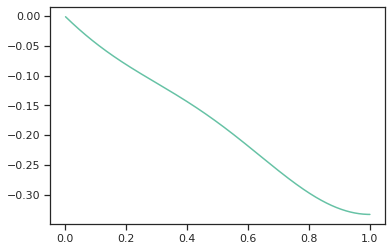

In [33]:
M = 500
A, F, x = generate_problem(f, M,
                           (BCType.VALUE, 0), 
                           (BCType.NEUMANN, 0)
                          )
U = np.linalg.solve(A, F)
plt.plot(x, U)
plt.show()

In [42]:
M_list = np.geomspace(10, 500, 10, dtype=int)
L2_discrete_errors = []
L2_continous_errors = []
L2_continous_errors_inter = []

BCs = [(BCType.VALUE, 0), (BCType.NEUMANN, 1)]

for M in M_list:
    A, F, x = generate_problem(f, M, *BCs)
    U = np.linalg.solve(A, F)
    analytical = partial(u, alpha=0, sigma=1)
    
    L2_discrete_errors.append(
        L2_discrete_error(U, analytical(x))
    )
    L2_continous_errors.append(
        L2_continous_error(step_continuation(U), analytical)
    )
    L2_continous_errors_inter.append(
        L2_continous_error(interpolation_continuation(U), analytical)
    )
    

<ipython-input-30-f71a24762ea0>:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return np.sqrt(quad(integrand, x_min, x_max)[0])  # quad from scipy.integrate


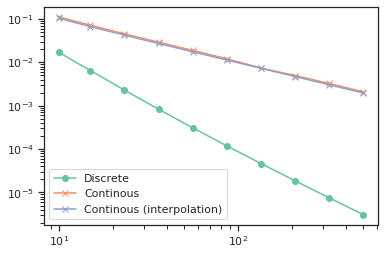

In [43]:
plt.plot(M_list, L2_discrete_errors, 'o-', label="Discrete")
plt.plot(M_list, L2_continous_errors, 'x-', label="Continous")
plt.plot(M_list, L2_continous_errors_inter, 'x-', label="Continous (interpolation)")
# plt.plot([1e2, 1e3, 1e3, 1e2], [10e-4, 10e-6, 10e-4, 10e-4], lw=0.5, c="gray")
plt.xscale('log')
plt.yscale('log')
plt.legend()
import tikzplotlib
tikzplotlib.save("convergence.tex")

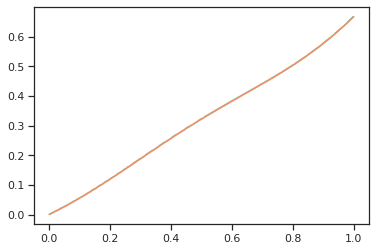

In [36]:
U_func = step_continuation(U)
plt.plot(x, U_func(x))
plt.plot(x, U)

In [37]:
np.linalg.norm(U)

8.259809387017555

In [38]:
np.sqrt(np.sum(U**2))

8.259809387017555

In [39]:
np.linspace(0, 1, 10).shape

(10,)